In [1]:
import sys
import os
import signal
import json
import numpy as np
import re
import json
from human_eval.data import read_problems
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class timeout:
    '''
    Timer for executed programs. Waits a specified number of seconds 
    after execution before singaling a TimeOut error.
    '''
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        # signal.alarm(self.seconds)
        signal.setitimer(signal.ITIMER_REAL, self.seconds)
    
    def __exit__(self, type, value, traceback):
        # signal.alarm(0)
        signal.setitimer(signal.ITIMER_REAL, 0)

def extract_function(code_string):
    '''
    Extracts a function definition from a code string.
    '''
    try:
        with timeout(seconds=0.1):
            # Regular expression to match a Python function definition
            function_pattern = r'(\bdef\s+\w+\(.*?\):\s*(?:[^#\n].*?\n|\s*#.*?\n)*?)(?:\n\s*|\s*#.*?$|\Z)'
            
            # Search for the function in the code string
            match = re.search(function_pattern, code_string, re.DOTALL)
            
            if match:
                return match.group(0)
            else:
                return code_string
    except:
        return code_string

def extract_testcase(text):
    '''
    Extracts test cases (as assert statements) from a model generation.
    '''
    try:
        with timeout(seconds=0.1):
            # Regular expression pattern to match 'assert x == y' or 'assert(x == y)'
            pattern1 = r'assert\s+\(?[^\n]*\s*==\s*[^\n]*\)?'
            pattern2 = r'assert\s*\(.*?=\s*.*?\)'
            
            # Find all matches in the text using the pattern
            matches1 = re.findall(pattern1, text)
            matches2 = re.findall(pattern2, text)

            if len(matches1) > 0:
                return matches1[0]
            elif len(matches2) > 0:
                return matches2[0]
            else:
                return text
    except:
        return text

def extract_function_header(code):
    header = code[:code.find(')')+2]
    if header[-1] == " ":
        header = header[:-1] + ":"
    return header

In [3]:
# with open('/home/rrsood/CodeGen/qwen_humaneval_programs_k100.jsonl') as f:
#     json_programs = [json.loads(line) for line in f]
# with open('/home/rrsood/CodeGen/qwen_humaneval_tests_k100.jsonl') as f:
#     json_tests = [json.loads(line) for line in f]

In [4]:
# res_programs = []
# res_tests = []
# problems = read_problems()
# for i in tqdm(range(164)):
#     task_id = 'HumanEval/%d' % i
#     for j in range(100 * i, 100 * (i+1)):
#         program_probs = json_programs[j]['logprobs']
#         test_probs = json_tests[j]['logprobs']
#         program = problems[task_id]['prompt'] + json_programs[j]['completion']
#         test = extract_testcase("assert" + json_tests[j]['completion'])
#         res_programs.append({'task_id' : task_id, 'completion' : program, 'logprobs' : program_probs})
#         res_tests.append({'task_id' : task_id, 'completion' : test, 'logprobs' : test_probs})

In [5]:
# from human_eval.data import write_jsonl
# write_jsonl('qwen_humaneval_programs_k100_NEW.jsonl', res_programs)
# write_jsonl('qwen_humaneval_tests_k100_NEW.jsonl', res_tests)

In [6]:
def pass_at_k(res_json_dir, ids_to_exclude):
    """
    Calculates exact pass@k score for JSON result file from CodeT results.
    """
    with open(res_json_dir) as f:
        res_json = json.load(f)
    task_ids = list(res_json.keys())
    base_res = [0 for _ in range(100)]
    plus_res = [0 for _ in range(100)]
    num_eval = 0
    
    for i, task_id in enumerate(task_ids):
        if 'base_results' not in res_json[task_id]:
            continue
        if task_id in ids_to_exclude:
            continue
        
        num_eval += 1
        
        base_prob_res = res_json[task_id]['base_results']
        plus_prob_res = res_json[task_id]['plus_results']

        for i in range(1, len(base_prob_res)):
            if base_prob_res[i-1]:
                base_prob_res[i] = 1
            if plus_prob_res[i-1]:
                plus_prob_res[i] = 1
        
        for i in range(len(base_prob_res)):
            base_res[i] += base_prob_res[i]
            plus_res[i] += plus_prob_res[i]

    base_res  = [x / num_eval for x in base_res]
    plus_res = [x / num_eval for x in plus_res]

    return base_res, plus_res

In [7]:
num_input_tests = [1, 2, 3, 4, 5, 10, 25, 50, 75, 100]
input_test_idx_map = {key : i for i, key in enumerate(num_input_tests)}
passk_values = [1, 5]

passk_scores_base1 = {k : [0 for _ in range(len(num_input_tests))] for k in passk_values}
passk_scores_plus1 = {k : [0 for _ in range(len(num_input_tests))] for k in passk_values}

for test in num_input_tests:
    res_json_dir = '/home/rrsood/CodeGen/codellama_codeT_results/humaneval/%dtest/codellama_humaneval_codet_result_dump_%dtest_run1.json' % (test, test)
    base, plus = pass_at_k(res_json_dir, set())

    for k in passk_values:
        passk_scores_base1[k][input_test_idx_map[test]] = base[k - 1]
        passk_scores_plus1[k][input_test_idx_map[test]] = plus[k - 1]


passk_scores_base2 = {k : [0 for _ in range(len(num_input_tests))] for k in passk_values}
passk_scores_plus2 = {k : [0 for _ in range(len(num_input_tests))] for k in passk_values}

for test in num_input_tests:
    res_json_dir = '/home/rrsood/CodeGen/codellama_codeT_results/mbpp/%dtest/codellama_mbpp_codet_result_dump_%dtest_run1.json' % (test, test)
    base, plus = pass_at_k(res_json_dir, set())

    for k in passk_values:
        passk_scores_base2[k][input_test_idx_map[test]] = base[k - 1]
        passk_scores_plus2[k][input_test_idx_map[test]] = plus[k - 1]

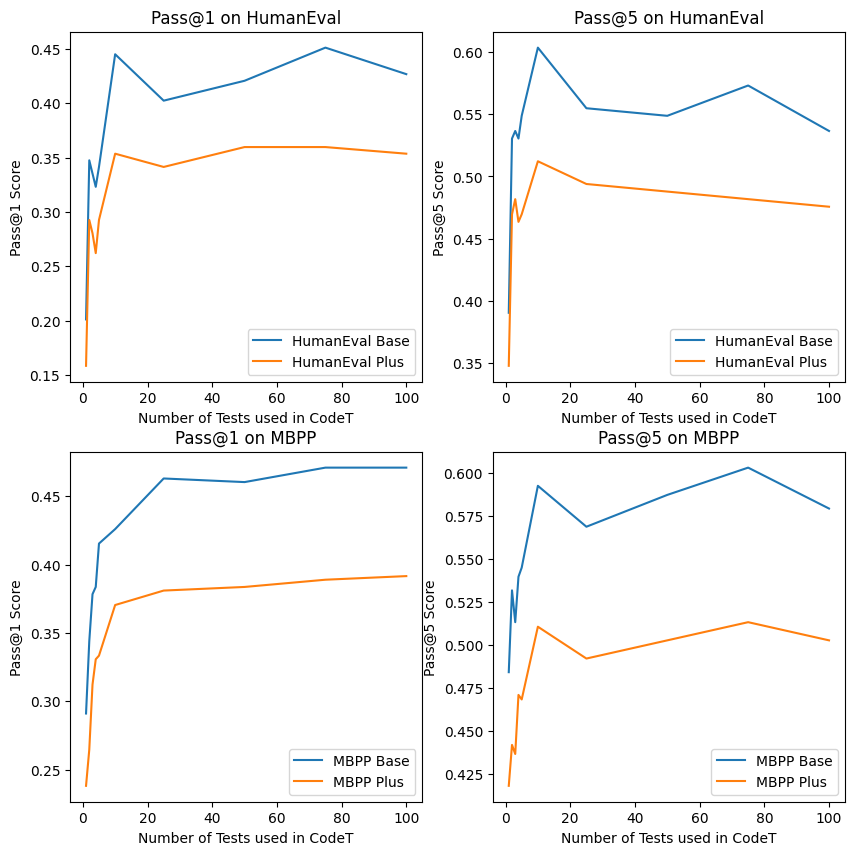

In [12]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax[0, 0].plot(num_input_tests, passk_scores_base1[1], label = "HumanEval Base")
ax[0, 0].plot(num_input_tests, passk_scores_plus1[1], label = 'HumanEval Plus')
ax[0, 0].set_ylabel("Pass@1 Score")
ax[0, 0].title.set_text("Pass@1 on HumanEval")
ax[0, 0].set_xlabel("Number of Tests used in CodeT")
ax[0, 0].legend(loc="lower right")


ax[0, 1].plot(num_input_tests, passk_scores_base1[5], label = "HumanEval Base")
ax[0, 1].plot(num_input_tests, passk_scores_plus1[5], label = 'HumanEval Plus')
ax[0, 1].set_ylabel("Pass@5 Score")
ax[0, 1].title.set_text("Pass@5 on HumanEval")
ax[0, 1].set_xlabel("Number of Tests used in CodeT")
ax[0, 1].legend(loc="lower right")


ax[1, 0].plot(num_input_tests, passk_scores_base2[1], label = "MBPP Base")
ax[1, 0].plot(num_input_tests, passk_scores_plus2[1], label = 'MBPP Plus')
ax[1, 0].set_ylabel("Pass@1 Score")
ax[1, 0].title.set_text("Pass@1 on MBPP")
ax[1, 0].set_xlabel("Number of Tests used in CodeT")
ax[1, 0].legend(loc="lower right")

ax[1, 1].plot(num_input_tests, passk_scores_base2[5], label = "MBPP Base")
ax[1, 1].plot(num_input_tests, passk_scores_plus2[5], label = 'MBPP Plus')
ax[1, 1].set_ylabel("Pass@5 Score")
ax[1, 1].title.set_text("Pass@5 on MBPP")
ax[1, 1].set_xlabel("Number of Tests used in CodeT")
ax[1, 1].legend(loc="lower right")

plt.show()

In [13]:
num_input_tests = [1, 2, 3, 4, 5, 10, 25, 50, 75, 100]
input_test_idx_map = {key : i for i, key in enumerate(num_input_tests)}
passk_values = [1, 5]

passk_scores_base1 = {k : [0 for _ in range(len(num_input_tests))] for k in passk_values}
passk_scores_plus1 = {k : [0 for _ in range(len(num_input_tests))] for k in passk_values}

for test in num_input_tests:
    res_json_dir = '/home/rrsood/CodeGen/qwen_codeT_results/humaneval/%dtest/qwen_humaneval_codet_result_dump_%dtest_run1.json' % (test, test)
    base, plus = pass_at_k(res_json_dir, set())

    for k in passk_values:
        passk_scores_base1[k][input_test_idx_map[test]] = base[k - 1]
        passk_scores_plus1[k][input_test_idx_map[test]] = plus[k - 1]


passk_scores_base2 = {k : [0 for _ in range(len(num_input_tests))] for k in passk_values}
passk_scores_plus2 = {k : [0 for _ in range(len(num_input_tests))] for k in passk_values}

for test in num_input_tests:
    res_json_dir = '/home/rrsood/CodeGen/qwen_codeT_results/mbpp/%dtest/qwen_mbpp_codet_result_dump_%dtest_run1.json' % (test, test)
    base, plus = pass_at_k(res_json_dir, set())

    for k in passk_values:
        passk_scores_base2[k][input_test_idx_map[test]] = base[k - 1]
        passk_scores_plus2[k][input_test_idx_map[test]] = plus[k - 1]

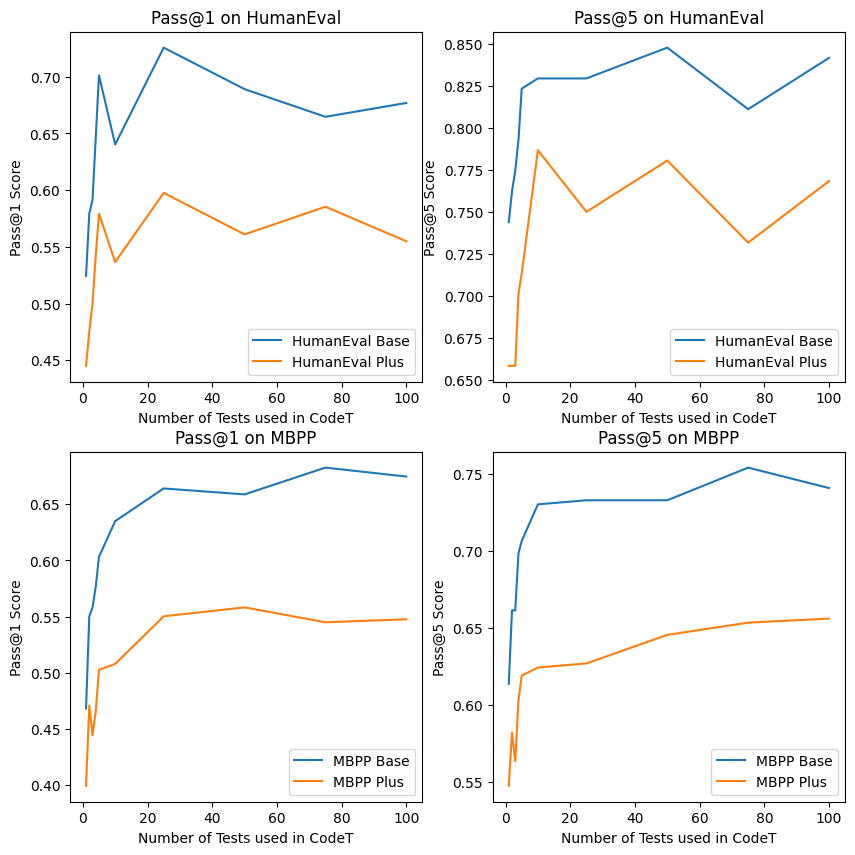

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax[0, 0].plot(num_input_tests, passk_scores_base1[1], label = "HumanEval Base")
ax[0, 0].plot(num_input_tests, passk_scores_plus1[1], label = 'HumanEval Plus')
ax[0, 0].set_ylabel("Pass@1 Score")
ax[0, 0].title.set_text("Pass@1 on HumanEval")
ax[0, 0].set_xlabel("Number of Tests used in CodeT")
ax[0, 0].legend(loc="lower right")


ax[0, 1].plot(num_input_tests, passk_scores_base1[5], label = "HumanEval Base")
ax[0, 1].plot(num_input_tests, passk_scores_plus1[5], label = 'HumanEval Plus')
ax[0, 1].set_ylabel("Pass@5 Score")
ax[0, 1].title.set_text("Pass@5 on HumanEval")
ax[0, 1].set_xlabel("Number of Tests used in CodeT")
ax[0, 1].legend(loc="lower right")


ax[1, 0].plot(num_input_tests, passk_scores_base2[1], label = "MBPP Base")
ax[1, 0].plot(num_input_tests, passk_scores_plus2[1], label = 'MBPP Plus')
ax[1, 0].set_ylabel("Pass@1 Score")
ax[1, 0].title.set_text("Pass@1 on MBPP")
ax[1, 0].set_xlabel("Number of Tests used in CodeT")
ax[1, 0].legend(loc="lower right")

ax[1, 1].plot(num_input_tests, passk_scores_base2[5], label = "MBPP Base")
ax[1, 1].plot(num_input_tests, passk_scores_plus2[5], label = 'MBPP Plus')
ax[1, 1].set_ylabel("Pass@5 Score")
ax[1, 1].title.set_text("Pass@5 on MBPP")
ax[1, 1].set_xlabel("Number of Tests used in CodeT")
ax[1, 1].legend(loc="lower right")

plt.show()